# The Helmholtz equation on the Torus

Helmholtz equation is given as

$$
\nabla^2 u + \alpha u = f.
$$

In this notebook we will solve this equation (without boundary conditions) on the surface of a torus, using curvilinear coordinates. The surface of the torus is parametrized by    

$$
\begin{align}
x(\theta, \phi) &= (R + r \cos \theta) \cos \phi \\
y(\theta, \phi) &= (R + r \cos \theta) \sin \phi \\
z(\theta, \phi) &= r \sin \theta
\end{align}
$$

where $\theta, \phi$ are angles which make a full circle, so that their values start and end at the same point, $R$ is the distance from the center of the tube to the center of the torus,
$r$ is the radius of the tube. Note that $\theta$ is the angle in the small circle (around its center), whereas $\phi$ is the angle of the large circle, around origo.

We start the implementation by importing necessary functionality from shenfun and sympy and then defining the coordinates of the surface of the torus. Note that `rv` represents the position vector spanning the surface.

In [1]:
from shenfun import *
from shenfun.la import SolverGeneric1ND
import sympy as sp
from IPython.display import Math

N = 80
R = 3
r = 1
theta, phi = psi = sp.symbols('x,y', real=True, positive=True)
rv = ((R + r*sp.cos(theta))*sp.cos(phi), (R + r*sp.cos(theta))*sp.sin(phi), r*sp.sin(theta)) 

Now create necessary bases and function spaces. Due to the geometry of the problem, the solution will be periodic in both $\theta$ and $\phi$ directions, and we choose Fourier basis functions. The basis for the $\phi$-direction can be either real to complex or complex to complex, depending on the type of the solution. Here we assume a real solution

In [2]:
B1 = FunctionSpace(N, 'F', dtype='D', domain=(0, 2*np.pi))
B2 = FunctionSpace(N, 'F', dtype='d', domain=(0, 2*np.pi))
T = TensorProductSpace(comm, (B1, B2), coordinates=(psi, rv, sp.Q.positive(r*sp.cos(theta)+R)))
V = VectorSpace(T)
u = TrialFunction(T)
v = TestFunction(T)
T.coors.sg

cos(x) + 3

Note the assumption `sp.Q.positive(r*sp.cos(theta)+R))`, which is there to help sympy when computing basis vectors and scaling factors. It is not completely necessary, but try to omit it and look at what happens to the expanded Helmholtz equation below.

In [3]:
alpha = 1
du = div(grad(u))+alpha*u
g = sp.Symbol('g', real=True, positive=True) # The Jacobian**2 (T.coors.sg**2)
replace = [(3*sp.cos(theta)+5, g/2), (sp.cos(theta)**2+6*sp.cos(theta)+10, sp.cos(theta)**2+g), (3*sp.cos(theta)+10, g/2+5)] # to simplify the look
Math(du.tolatex(symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}, replace=replace))

<IPython.core.display.Math object>

We now create a manufactured solution that satisfies periodicity and compute the right hand side $f$.

In [4]:
ue = sp.sin(theta*2)*sp.cos(4*phi)
f = (div(grad(u))+alpha*u).tosympy(basis=ue, psi=psi)
fj = Array(T, buffer=f*T.sg)
f_hat = Function(T)
f_hat = inner(v, fj, output_array=f_hat)

Assemble coefficient matrix and solve problem. Note that the tensorproduct matrices along axis 0 can be non-diagonal due to the measure $\cos \theta + 3$. The matrices along the second axis will all be diagonal, so we can choose to use `SolverGeneric1ND`

In [5]:
mats = inner(v*T.sg, (div(grad(u))+alpha*u))
#mats = inner(grad(v), -grad(u)) + inner(v, alpha*u)
u_hat = Function(T)
sol = SolverGeneric1ND(mats)
u_hat = sol(f_hat, u_hat)
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.linalg.norm(uj-uq))

Error = 4.498676817086259e-14


/Users/mikaelmortensen/MySoftware/shenfun/shenfun/matrixbase.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  u.real[:] = self._lu.solve(b.real)
/Users/mikaelmortensen/MySoftware/shenfun/shenfun/matrixbase.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  u.imag[:] = self._lu.solve(b.imag)


In [6]:
mats = inner(v*T.sg, u, level=2)

In [7]:
K = T.local_wavenumbers()
mats[0].mats[0]

{0: array([9.5+0.00000000e+00j, 9.5+1.37859974e-16j, 9.5+2.34551936e-16j,
        9.5+5.99173866e-17j, 9.5+1.15554059e-16j, 9.5+1.10303098e-16j,
        9.5-5.30357113e-18j, 9.5+4.24920009e-18j, 9.5-7.48218879e-17j,
        9.5-1.94709549e-17j, 9.5+2.02952128e-18j, 9.5+6.70256712e-18j,
        9.5+7.24952694e-17j, 9.5+6.11449729e-18j, 9.5+3.28119264e-17j,
        9.5-6.18121888e-17j, 9.5+2.97603134e-17j, 9.5-5.73143327e-17j,
        9.5+2.98491099e-17j, 9.5-5.97540404e-18j, 9.5-1.18329136e-30j,
        9.5-3.87139095e-17j, 9.5+1.40842997e-17j, 9.5+1.41399053e-17j,
        9.5+3.83750209e-17j, 9.5+4.71892148e-17j, 9.5+9.53825728e-18j,
        9.5-4.13798647e-17j, 9.5-1.58793742e-17j, 9.5+1.65647284e-17j,
        9.5+2.31592799e-17j, 9.5-5.50530416e-17j, 9.5-2.36235065e-18j,
        9.5+2.98743716e-17j, 9.5-2.14338569e-17j, 9.5-1.72549854e-16j,
        9.5-8.18086720e-17j, 9.5-4.39545939e-17j, 9.5+3.57735431e-16j,
        9.5-2.08523833e-19j, 9.5+6.31088724e-30j, 9.5+2.08523833e-19j,
   

Finally, just plot the solution using mayavi. Wrap the periodic directions around and refine to get a nicer plot.

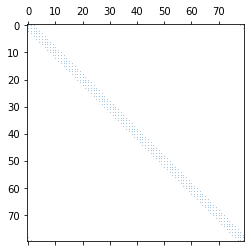

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#B = sol.diags(4, 'csr')
#print(np.linalg.cond(B.toarray()))
#len(sol.MM)
plt.spy(sol.MM[4].diags(), markersize=0.1)

In [9]:
from mayavi import mlab
u_hat2 = u_hat.refine([N*2, N*2])
ur = u_hat2.backward()
xx, yy, zz = u_hat2.function_space().local_cartesian_mesh()
#xx = np.hstack([xx, xx[:, 0][:, None]])
#yy = np.hstack([yy, yy[:, 0][:, None]])
#zz = np.hstack([zz, zz[:, 0][:, None]])
#ur = np.hstack([ur, ur[:, 0][:, None]])
xx = np.vstack([xx, xx[0]])
yy = np.vstack([yy, yy[0]])
zz = np.vstack([zz, zz[0]])
ur = np.vstack([ur, ur[0]])
mlab.figure(bgcolor=(1, 1, 1))
mlab.mesh(xx, yy, zz, scalars=ur.real, colormap='jet')
mlab.savefig('torus.png')
mlab.show()

In [10]:
plot3D(u_hat2)

NameError: name 'plot3D' is not defined